<a href="https://colab.research.google.com/github/adenikeadewumi/EEE_254/blob/main/british_airway_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os

In [ ]:
# Get reviews from their website

base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [ ]:
#Create a pandas dataframe from the reviews
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | I had an appalling experie...
1,"Not Verified | Good points, the cabin crew, t..."
2,"Not Verified | It was a decent flight, reason..."
3,✅ Trip Verified | I really like flying Briti...
4,✅ Trip Verified | Could not book online the ...


In [ ]:

#Save dataset
os.makedirs("data", exist_ok=True)

df.to_csv("data/BA_reviews.csv", index=False)


In [ ]:
df= pd.read_csv("data/BA_reviews.csv")

In [ ]:
df.head()

,reviews
0,✅ Trip Verified | I had an appalling experie...
1,"Not Verified | Good points, the cabin crew, t..."
2,"Not Verified | It was a decent flight, reason..."
3,✅ Trip Verified | I really like flying Briti...
4,✅ Trip Verified | Could not book online the ...


In [ ]:
#Get verification status from data
def get_verification_status(text):
    if "✅ Trip Verified" in text:
        return "Yes"
    else:
        return "No"

df["Verified"]= df["reviews"].apply(get_verification_status)

In [ ]:
df.head()

,reviews,Verified
0,✅ Trip Verified | I had an appalling experie...,Yes
1,"Not Verified | Good points, the cabin crew, t...",No
2,"Not Verified | It was a decent flight, reason...",No
3,✅ Trip Verified | I really like flying Briti...,Yes
4,✅ Trip Verified | Could not book online the ...,Yes


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
# Define function to remove the first part of review
def remove_first_part(text):
    parts = text.split(" | ")
    if len(parts) > 1:
        return parts[1]
df["reviews"]= df["reviews"].apply(remove_first_part)

In [ ]:
df.head()

,reviews,Verified
0,I had an appalling experience with British A...,Yes
1,"Good points, the cabin crew, they were helpfu...",No
2,"It was a decent flight, reasonable comfortabl...",No
3,I really like flying British Airways particu...,Yes
4,None,Yes


In [ ]:
df.isnull().sum()
df.dropna(inplace=True)

In [ ]:
df.info()
# Since we are not building a model we do not need to remove null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reviews   965 non-null    object
 1   Verified  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [ ]:
#Install required packages

!pip install pandas spacy nltk
!python -m nltk.downloader vader_lexicon
!python -m spacy download en_core_web_sm


<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
import nltk
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Download and set up VADER
nltk.download("vader_lexicon")
vader = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:

# Function to extract features
def extract_features(text):
    doc = nlp(text)

    # Sentiment Scores
    sentiment = vader.polarity_scores(text)

    # Length Features
    num_chars = len(text)
    num_words = len(text.split())

    # Presence of specific topics (example: can be expanded)
    has_website_issue = int(bool(re.search(r'website error|check in|online', text, re.I)))
    has_rude_staff = int(bool(re.search(r'rude|unprofessional|ignored|refused', text, re.I)))
    has_baggage_issue = int(bool(re.search(r'luggage|bag|baggage', text, re.I)))
    has_medical_issue = int(bool(re.search(r'medical|pain|hospital|collapsed|stretcher', text, re.I)))

    # NER Extraction
    airline = ""
    for ent in doc.ents:
        if ent.label_ == "ORG" and "airways" in ent.text.lower():
            airline = ent.text

    return pd.Series({
        "airline": airline,
        "review_length": num_chars,
        "word_count": num_words,
        "sentiment_neg": sentiment["neg"],
        "sentiment_neu": sentiment["neu"],
        "sentiment_pos": sentiment["pos"],
        "sentiment_compound": sentiment["compound"],
        "website_issue": has_website_issue,
        "rude_staff": has_rude_staff,
        "baggage_issue": has_baggage_issue,
        "medical_issue": has_medical_issue,
    })

# Apply the function
features_df = df["reviews"].apply(extract_features)
result = pd.concat([df, features_df], axis=1)

# Show result
result.head()


,reviews,Verified,airline,review_length,word_count,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound,website_issue,rude_staff,baggage_issue,medical_issue
0,I had an appalling experience with British A...,Yes,British Airways,1637,271,0.212,0.703,0.085,-0.9924,1,1,1,1
1,"Good points, the cabin crew, they were helpfu...",No,,1213,211,0.079,0.839,0.082,0.5625,1,0,0,0
2,"It was a decent flight, reasonable comfortabl...",No,,597,108,0.092,0.776,0.131,0.4054,0,0,0,0
3,I really like flying British Airways particu...,Yes,British Airways,721,135,0.025,0.796,0.179,0.9652,0,0,0,0
5,Having had some rough experiences with BA in r...,Yes,,370,66,0.000,0.811,0.189,0.9150,0,0,0,0


In [57]:
#Save new dataset
result.to_csv("data/processed_BA_reviews.csv", index=False)


In [ ]:
#Create function to cassify sentiment compound
def classify_sentiment(compound_score):
    if compound_score >= 0.6:
        return "strongly positive"
    elif compound_score >= 0.2:
        return "positive"
    elif compound_score > -0.2:
        return "neutral"
    elif compound_score > -0.6:
        return "negative"
    else:
        return "strongly negative"


result["sentiment_compound"] = result["sentiment_compound"].apply(classify_sentiment)


In [ ]:
result.head()

,reviews,Verified,airline,review_length,word_count,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound,website_issue,rude_staff,baggage_issue,medical_issue
0,I had an appalling experience with British A...,Yes,British Airways,1637,271,0.212,0.703,0.085,strongly negative,1,1,1,1
1,"Good points, the cabin crew, they were helpfu...",No,,1213,211,0.079,0.839,0.082,positive,1,0,0,0
2,"It was a decent flight, reasonable comfortabl...",No,,597,108,0.092,0.776,0.131,positive,0,0,0,0
3,I really like flying British Airways particu...,Yes,British Airways,721,135,0.025,0.796,0.179,strongly positive,0,0,0,0
5,Having had some rough experiences with BA in r...,Yes,,370,66,0.000,0.811,0.189,strongly positive,0,0,0,0


In [ ]:
result.isnull().sum()

,0
reviews,0
Verified,0
airline,0
review_length,0
word_count,0
sentiment_neg,0
sentiment_neu,0
sentiment_pos,0
sentiment_compound,0
website_issue,0


In [58]:
counter=0

for i in result["rude_staff"]:
  if i==1:
    counter+=1
print(counter)

103


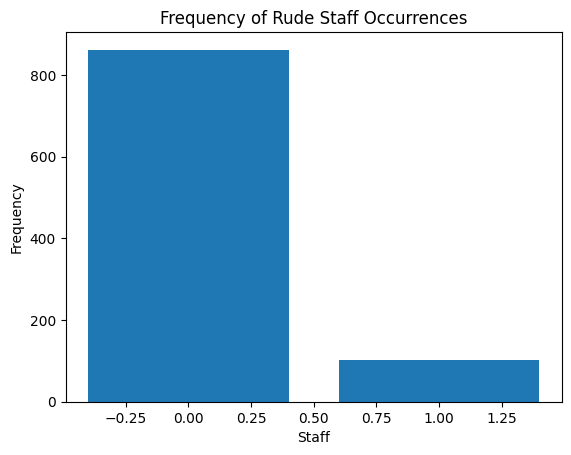

Index([0, 1], dtype='int64', name='rude_staff')


In [ ]:
#Plot bar chart to show number of reviews about rude staff
import matplotlib.pyplot as plt

# Count the occurrences of each unique value in "rude_staff"
rude_staff_counts = result["rude_staff"].value_counts()

# Create the bar chart
plt.bar([0,1], rude_staff_counts.values)
plt.xlabel('Review on staff')
plt.ylabel('Frequency')
plt.title('Frequency of Rude Staff Occurrences')
plt.show()

In [ ]:
st_pos=0
st_neg=0
neg=0
pos=0
neutral=0
sentiment_list = [i for i in result['sentiment_compound']]


for i in sentiment_list:
  if i=="strongly positive":
    st_pos+=1
  elif i== "strongly negative":
    st_neg+=1
  elif i== "negative":
    neg+=1
  elif i== "positive":
    pos+=1
  else:
    neutral+=1

overall_pos= st_pos+ pos
overall_neg= st_neg + neg
print(st_pos)
print(st_neg)
print(neg)
print(pos)
print(neutral)
print(f"Overall egative reviews is {overall_neg}")
print(f"Overall positve: {overall_pos}")


361
385
95
71
53
Overall egative reviews is 480
Overall positve: 432


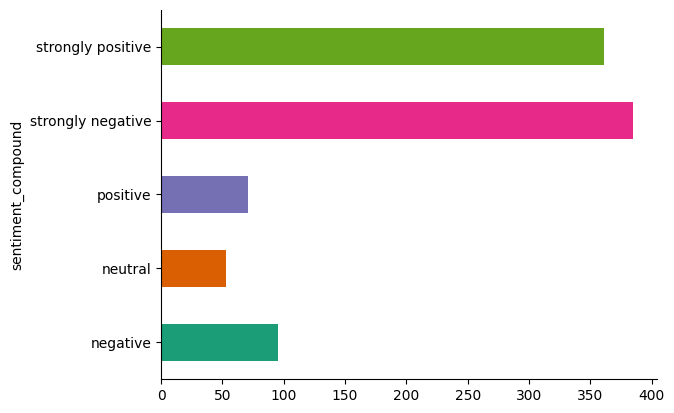

In [ ]:
import seaborn as sns
result.groupby('sentiment_compound').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

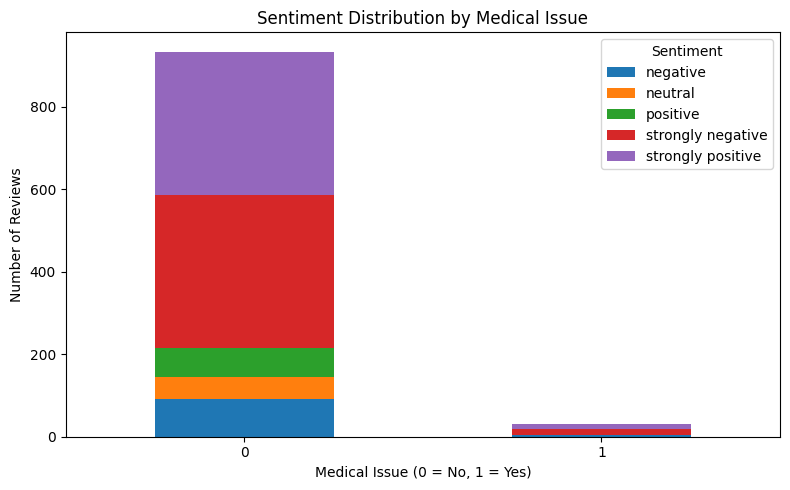

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group and count
sentiment_vs_medical = result.groupby(['medical_issue', 'sentiment_compound']).size().unstack(fill_value=0)

# Plot
sentiment_vs_medical.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Sentiment Distribution by Medical Issue')
plt.xlabel('Medical Issue (0 = No, 1 = Yes)')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


From this plot, it can be seen that there us an issue with the hospitality status of those with health issues.

In [60]:
count= []
counter_rs=0
counter_mi=0
counter_bi=0
for i in result["rude_staff"]:
  if i==1:
    counter_rs+=1
print(counter_rs)


for i in result["medical_issue"]:
  if i==1:
    counter_mi+=1
print(counter_mi)


for i in result["baggage_issue"]:
  if i==1:
    counter_bi+=1
print(counter_bi)

count.append(counter_mi)
count.append(counter_bi)
count.append(counter_rs)

103
31
287


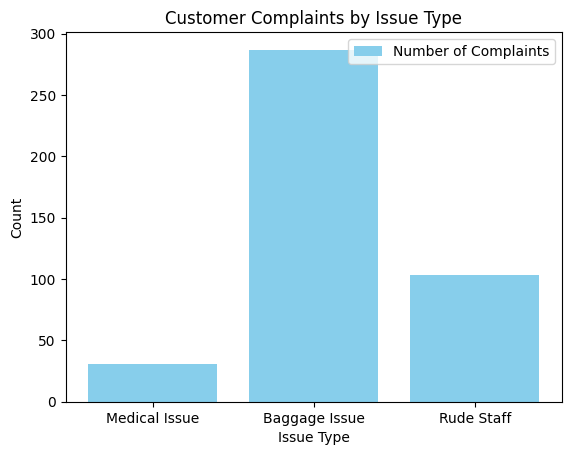

In [62]:
import matplotlib.pyplot as plt

# Example data
categories = ['Medical Issue', 'Baggage Issue', 'Rude Staff']
# Create the bar plot
plt.bar(categories, count, label='Number of Complaints', color='skyblue')

# Add legend
plt.legend()

# Add titles and labels for clarity
plt.title('Customer Complaints by Issue Type')
plt.xlabel('Issue Type')
plt.ylabel('Count')

# Show plot
plt.show()